# Opening Access to Fast Radio Interferometric Imaging

### a.k.a. A Quick Demo of rtpipe

My science interests lie in fast radio transients, such as "[fast radio bursts](https://en.wikipedia.org/wiki/Fast_radio_burst)". But, frankly, a big part of why I enjoy studying these things is that it motivates a lot of fun and challenging work with software, algorithms, and data.

One example of that is our ongoing effort at the Very Large Array to do "fast imaging" --- forming images at millisecond cadence --- for massive transient surveys. Massive in this context is both in time (we've conducted a 200-hour survey and are in the midst of another) and data (1 hours on sky => 1 TB of data!). Doing this right requires a lot of custom software development, including the library I'm demoing here: [`rtpipe`](http://github.com/caseyjlaw/rtpipe).

`rtpipe` is a library for radio interferometric data analysis that combines single-dish concepts like dedispersion and filters with interferometric concepts like images, the uv-plane, etc.. But it is probably more generally useful if you are interested in custom radio interferometric data analysis. If you are, then I highly recommend browsing the github contributions and blog of [Peter Williams](http://newton.cx/~peter). Peter contributed both code and advice that helped shape `rtpipe` (the mistakes are mine, though).

So, on with the demo...

Let's say you download one of the [many public, TB-scale, VLA fast imaging data sets](https://archive.nrao.edu/archive/ArchiveQuery?QUERYTYPE=ARCHIVE&PROJECT_CODE=14A-425) from the NRAO archive. `rtpipe` lets you read and visualize that data in python, but of course most importantly, it lets one search it for fast radio transients. 


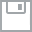
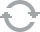
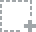
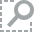
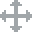
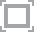
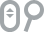
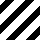
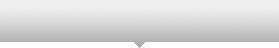
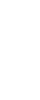
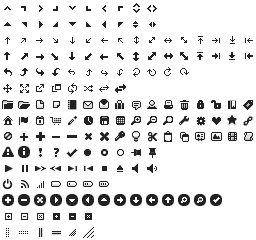
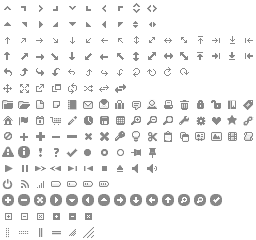
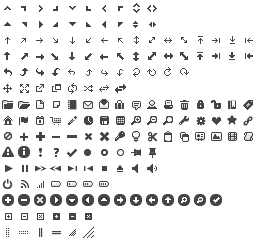
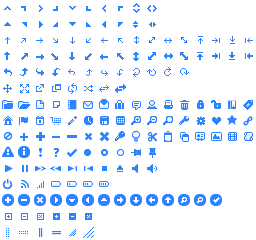
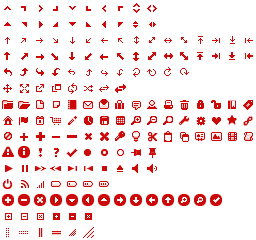
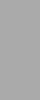
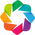
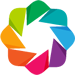

In [1]:
import rtpipe.RT as rt
import rtpipe.parsesdm as ps
import rtpipe.parsecal as pc
import rtlib_cython as rtlib
from bokeh.plotting import figure, show
from bokeh.io import output_notebook, gridplot
output_notebook()

Note that we're using [bokeh](http://bokeh.pydata.org), a library for interactive visualization in python (similar to the popular `D3.js` stuff you see a lot in the NY Times). Bokeh also easily supports visualization embedded in an IPython notebook, as you can see!

For the purposes of searching for transients, `rtpipe` is centered on the idea of building a dictionary that defines the state of the pipeline. In other contexts, this state would be encompassed in a class, but that doesn't play so well with Python's multiprocessing library, so I ended up building everything into a dict. One nice thing about this design is that this dictionary can be attached as metadata to the products (Python pickle files) of the search. It makes reproducing the results and understanding the data products straightforward. 

In [2]:
d = rt.set_pipeline('14A-425_sb29612394_1.56903.3271372338', 22, nsegments=200, sigma_image1=10, 
                    dmarr=[57.], nologfile=True, chans=range(3,125)+range(131,253))

INFO:rtpipe.parsesdm:

INFO:rtpipe.parsesdm:Metadata summary:
INFO:rtpipe.parsesdm:	 Working directory and data at /ipynb, 14A-425_sb29612394_1.56903.3271372338
INFO:rtpipe.parsesdm:	 Using scan 22, source B0355+54 7mN
INFO:rtpipe.parsesdm:	 nants, nbl: 27, 351
INFO:rtpipe.parsesdm:	 Freq range (1.271 -- 1.520). 2 spw with 244 chans.
INFO:rtpipe.parsesdm:	 Scan has 6780 ints (33.9 s) and inttime 0.005 s
INFO:rtpipe.parsesdm:	 2 polarizations: ['RR', 'LL']
INFO:rtpipe.parsesdm:	 Ideal uvgrid npix=(128,192) and res=53 (oversample 1.0)
INFO:rtpipe.RT:Autodetected telcal file /ipynb/14A-425_sb29612394_1.56903.3271372338.GN
INFO:rtpipe.RT:
INFO:rtpipe.RT:Pipeline summary:
INFO:rtpipe.RT:	 Products saved with 14A-425_sb29612394_1.56903.3271372338. telcal calibration with 14A-425_sb29612394_1.56903.3271372338.GN
INFO:rtpipe.RT:	 Using 200 segments of 43 ints (0.2 s) with overlap of 0.0 s
INFO:rtpipe.RT:	 Downsampling in time/freq by 1/1 and skipping 0 ints from start of scan.
INFO:rtpipe.RT:	

So we've defined a state dictionary d for a single scan (VLA jargon for an observation of a source) of an observation. This observation was pointed at the pulsar B0355+54, which is bright and will produce pulses easy to detect in this simple analysis.

Next, we use `rtpipe.parsesdm` to read in a bit of data for visualization. We read directly from the SDM format data , which is what's provided by the NRAO archive. Thanks to Peter's contribution of [sdmreader](http://github.com/caseyjlaw/sdmreader), we no longer need to convert to MS format.

In [3]:
segment=18 # chosen not-at-all at random
data = ps.read_bdf_segment(d, segment)
print 'Data shape of (integrations, baselines, channels, polarizations) = %s' % (str(data.shape))

INFO:rtpipe.parsesdm:Reading segment 18/199, times 08:34:07.097 to 08:34:07.311
INFO:rtpipe.parsesdm:Found online flags for 317 antenna/time ranges.
INFO:rtpipe.parsesdm:Applied online flags to 43 ints.


Data shape of (integrations, baselines, channels, polarizations) = (43, 351, 244, 2)


Note that `rtpipe` also has the concept of a "segment", which is a single set of integrations that are read and treated homogeneously. Typically, radio interferometry software will treat each integration independently in terms of calibration and flagging; they are ultimately combined to form sensitive images. However, `rtpipe` is purely focused on speed and one way to get speed is to vectorize many operations over the time axis. When calculating uv coordinates or subtracting sources, a segment is defined to be short enough to assume that calculations at time mid-point of the segment are valid over the entire segment. (Here, we've actually forced a large number of segments for purposes of controlling memory usage.)

Next, we parse gain calibration from "telcal" files. These are calibration products produced automatically by the VLA system for all calibrator scans. They are typically used for phasing the array (e.g., for pulsar observations), but they are also good for rough calibration. In practice, at L-band (1-2 GHz), the telcal solutions are 90% of the way to a hand-tuned, CASA-based calibration with bandpasses, etc.. Since fast imaging is relatively low sensitivity, telcal is good for our purposes.

In [4]:
solutions = pc.telcal_sol('14A-425_sb29612394_1.56903.3271372338.GN')
solutions.set_selection(d['segmenttimes'][segment].mean(), d['freq']*1e9, rtlib.calc_blarr(d))
solutions.apply(data)

A variety of flagging algorithms exist in `rtpipe`. They are fairly ad hoc and based on my experience playing with fast sampled data (e.g., flag high channels/times). The selection of the algorithm and paramaters for each algorithm are defined in the state dictionary. By default, three flag algorithms are used, each of which iterates over the two polarizations and two spectral windows.

In [5]:
rt.dataflag(d, data)

INFO:rtpipe.RT:Bad chans/ints flagging for (chans 0-121, pol 0), 4 sigma: 1 chans, 0 ints, 0.20 % of total flagged
INFO:rtpipe.RT:Bad chans/ints flagging for (chans 0-121, pol 1), 4 sigma: 2 chans, 0 ints, 0.41 % of total flagged
INFO:rtpipe.RT:Bad chans/ints flagging for (chans 122-243, pol 0), 4 sigma: 1 chans, 0 ints, 0.20 % of total flagged
INFO:rtpipe.RT:Bad chans/ints flagging for (chans 122-243, pol 1), 4 sigma: 1 chans, 0 ints, 0.20 % of total flagged
INFO:rtpipe.RT:Bad basepol flagging for chans 0-121 at 3.0 sigma: ants/pols []/[], 0.00 % of total flagged
INFO:rtpipe.RT:Bad basepol flagging for chans 0-121 at 3.0 sigma: ants/pols []/[], 0.00 % of total flagged
INFO:rtpipe.RT:Bad basepol flagging for chans 122-243 at 3.0 sigma: ants/pols []/[], 0.00 % of total flagged
INFO:rtpipe.RT:Bad basepol flagging for chans 122-243 at 3.0 sigma: ants/pols []/[], 0.00 % of total flagged
INFO:rtpipe.RT:Blstd flagging for (chans 0-121, pol 0), 3.0 sigma: 0.00 % of total flagged
INFO:rtpipe.R

So, now we have calibrated, flagged visibilities in a numpy array. What's it look like? One simple test is to form a Stokes I, phased array beam by summing over baselines and polarizations. That gives us a 2d data spectrogram to view (and a chance to show off interactive plotting!)

In [6]:
dd = data.mean(axis=3).mean(axis=1).real.transpose()
p = figure(plot_width=300, plot_height=800, x_range=(0, len(dd[0])), y_range=(0,len(dd)))
p.image(image=[dd], x=[0], y=[0], dw=[len(dd[0])], dh=[len(dd)], palette='Greys9')
p.xaxis.axis_label='Integration'
p.yaxis.axis_label='Channel'
show(p)

Wow, look at those pixels. But wait, there is no pulse here. I chose a segment of time which I know includes one, so where is it? 

The pulsar must be somewhere other than the phase center! By summing visibility data as I did above, we effectively produce a single synthesized beam (a few tens of arcsec for this D-config VLA data) on the sky.

So how do we find the pulse? Imaging!

In [7]:
d['silent'] = True  # suppress some logging
rt.pipeline(d, segment)

INFO:rtpipe.RT:Starting search of /ipynb/14A-425_sb29612394_1.56903.3271372338, scan 22, segments [18]
INFO:rtpipe.RT:Searching in 1 chunks with 1 threads
INFO:rtpipe.parsesdm:Reading segment 18/199, times 08:34:07.097 to 08:34:07.311
INFO:rtpipe.parsesdm:Found online flags for 317 antenna/time ranges.
INFO:rtpipe.parsesdm:Applied online flags to 43 ints.
INFO:rtpipe.parsesdm:Calculating uvw for segment 18
INFO:rtpipe.RT:Flagging with flaglist: [('badchtslide', 4.0, 0.0), ('badap', 3.0, 0.2), ('blstd', 3.0, 0.05)]
INFO:rtpipe.RT:Bad chans/ints flagging for (chans 0-121, pol 0), 4 sigma: 1 chans, 0 ints, 0.20 % of total flagged
INFO:rtpipe.RT:Bad chans/ints flagging for (chans 0-121, pol 1), 4 sigma: 2 chans, 0 ints, 0.41 % of total flagged
INFO:rtpipe.RT:Bad chans/ints flagging for (chans 122-243, pol 0), 4 sigma: 1 chans, 0 ints, 0.20 % of total flagged
INFO:rtpipe.RT:Bad chans/ints flagging for (chans 122-243, pol 1), 4 sigma: 1 chans, 0 ints, 0.20 % of total flagged
INFO:rtpipe.RT:B

Got one! The pipeline dedispersed at the known DM of the pulsar and imaged each integration in the segment. In integration 21, it found a peak in the image with a significance of 14.6. That exceeds a threshold we defined when initializing the pipeline state d, so it is reported. If we chose to save candidate information, it would also have written a pickle file out with the location of the state dictionary, candidate location, and a few features.

Now that we know the location of the candidate in the data, let's reproduce it for visualization. This is redundant with what we've done earlier, but is pretty quick so what the heck.

In [8]:
candim,canddata = rt.pipeline_reproduce(d, [segment, 21, 0, 0, 0], product='imdata')

INFO:rtpipe.RT:Reproducing candidate...
INFO:rtpipe.parsesdm:Reading segment 18/199, times 08:34:07.097 to 08:34:07.311
INFO:rtpipe.parsesdm:Found online flags for 317 antenna/time ranges.
INFO:rtpipe.parsesdm:Applied online flags to 43 ints.
INFO:rtpipe.parsesdm:Calculating uvw for segment 18
INFO:rtpipe.RT:Flagging with flaglist: [('badchtslide', 4.0, 0.0), ('badap', 3.0, 0.2), ('blstd', 3.0, 0.05)]
INFO:rtpipe.RT:Bad chans/ints flagging for (chans 0-121, pol 0), 4 sigma: 1 chans, 0 ints, 0.20 % of total flagged
INFO:rtpipe.RT:Bad chans/ints flagging for (chans 0-121, pol 1), 4 sigma: 2 chans, 0 ints, 0.41 % of total flagged
INFO:rtpipe.RT:Bad chans/ints flagging for (chans 122-243, pol 0), 4 sigma: 1 chans, 0 ints, 0.20 % of total flagged
INFO:rtpipe.RT:Bad chans/ints flagging for (chans 122-243, pol 1), 4 sigma: 1 chans, 0 ints, 0.20 % of total flagged
INFO:rtpipe.RT:Bad basepol flagging for chans 0-121 at 3.0 sigma: ants/pols []/[], 0.00 % of total flagged
INFO:rtpipe.RT:Bad basep

Gridded 1.000 of data. Scaling fft by = 0.2
Pixel sizes (60.8", 40.5"), Field size 3891.8"


This function can return a few types of data, but we chose to get the detection image and data that has been dedispersed and phased to the detection (that removes the baseline axis of the numpy array). 

So, is this a good candidate or not?

In [9]:
pim = figure(plot_width=300, plot_height=300, x_range=(0,len(candim[0])), y_range=(0,len(candim)))
pim.image(image=[candim.transpose()], x=[0], y=[0], dw=[len(candim[0])], dh=[len(candim)], palette='Greys9')
pim.xaxis.axis_label='RA (pixels)'
pim.yaxis.axis_label='Dec (pixels)'

show(pim)

In [10]:
dd = canddata.mean(axis=2).real.transpose()
psp = figure(plot_width=150, plot_height=400, x_range=(0, len(dd[0])), y_range=(0,len(dd)))
psp.image(image=[dd], x=[0], y=[0], dw=[len(dd[0])], dh=[len(dd)], palette='Greys9')
psp.xaxis.axis_label='Integration'
psp.yaxis.axis_label='Channel'

psp2 = figure(plot_width=200, plot_height=400)
window = 10
meanamp = [sum(dd[i-window/2:i+window/2,15]) for i in range(window/2, len(dd)-window/2)]
psp2.line(meanamp, range(len(meanamp)))
psp2.xaxis.axis_label='Smoothed Amp'
psp2.yaxis.axis_label='Channel'
p = gridplot([[psp, psp2]])
show(p)

And there we have an image and dedispersed spectrum for the candidate pulse. The source in the image shows sidelobes, as expected for this super-snapshot, 5 ms image. Spectrum shows scintillation, as expected for this pulsar.

There's a lot more to `rtpipe`, such as how we parallelize the search over many DMs, how candidates are saved, visualized, and refined after detection, how we have deployed it in a range of computing environments, and our ambitions for future developments such as periodicity imaging. 

For now, this post is intended to demonstrate how Python made it possible to apply interferometers to the study of fast transients. The software is open source and pip installable, and hundreds of TB of data are public. I'm having fun with this and I hope others can, too.